

IMPORTANT: the notebook's native use is in Colab environment since we use bash commands for installing libraries and other packages. For this reason if you want to run you can open the link from here:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1uAJDAoIFLmpo7YRYwrVv9roIZi-_gQ3N?authuser=1#scrollTo=B1TavIo6LjPQ&uniqifier=11)

Installing needed packages...

In [ ]:
%%capture
!pip install jsonlines
!pip install fasttext
!pip install jinja2

Importing needed libraries...

In [ ]:
import pandas as pd
from google.colab import drive
import jsonlines
import json
import fasttext
import fasttext.util
import numpy as np
import random
import gzip
import shutil
import re
import nltk
from nltk import word_tokenize, pos_tag
import jinja2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Downloading the dataset La Ghigliottina from https://ghigliottin-ai.github.io/dataset.json, the FastText model used for the distractors generation, the Italian Dictionary from my repository and the Italian stop words.

In [ ]:
#download the dataset using wget

!wget -O GhigliottinaDataset.json "https://ghigliottin-ai.github.io/dataset.json"
!wget -O cc.it.300.bin.gz "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.bin.gz"
!wget -O dizionario.txt "https://github.com/EmaMule/MNLP/raw/main/dizionario.txt"
!wget -O stopwords-it.txt "https://raw.githubusercontent.com/stopwords-iso/stopwords-it/master/stopwords-it.txt"

--2024-04-07 10:20:10--  https://ghigliottin-ai.github.io/dataset.json
Resolving ghigliottin-ai.github.io (ghigliottin-ai.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to ghigliottin-ai.github.io (ghigliottin-ai.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43138 (42K) [application/json]
Saving to: ‘GhigliottinaDataset.json’

GhigliottinaDataset 100%[===================>]  42.13K  --.-KB/s    in 0.01s   

2024-04-07 10:20:11 (3.92 MB/s) - ‘GhigliottinaDataset.json’ saved [43138/43138]

--2024-04-07 10:20:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502592726 (4.2G) [application/octet-stream]
Saving to: ‘cc.it.3

Decompressing the model parameters...

In [ ]:
# Path to the downloaded compressed model file
compressed_model_path = 'cc.it.300.bin.gz'
uncompressed_model_path = 'cc.it.300.bin'

# Decompress the model
with gzip.open(compressed_model_path, 'rb') as f_in:
    with open(uncompressed_model_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

!rm -rf "cc.it.300.bin.gz"

Setting the seed for enforcing repeatability

In [ ]:
random.seed(42)

Loading the models parameters...

In [ ]:
ft = fasttext.load_model('cc.it.300.bin')

In [ ]:
with open("dizionario.txt", 'r') as f:
    read_list = f.readlines()
with open("stopwords-it.txt", 'r') as f:
    stopwords_list = f.readlines()

italian_vocab = [word.strip(" \n\"") for word in read_list]
stopwords = [word.strip(" \n\"") for word in stopwords_list]

Funciton to evaluate the cosine similarity of two vectors.

In [ ]:
def cosine_similarity(vector1, vector2):
    similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return similarity

Naive solution for distractors generation.

Solution performed as single student.

As commented in the report, I extract three random words from the built dictionary that are different from given_words and the solution.

In [ ]:
def generate_distractors(given_words, solution):
    # Assuming italian_vocab and stopwords are defined somewhere
    similar_words = list(set(italian_vocab) - set(stopwords))

    # Remove words from given_words and solution
    similar_words = [word for word in similar_words if word not in given_words and word != solution]

    # Make sure there are enough words to sample from

    # Sample three different words
    sampled_words = random.sample(similar_words, 3)
    print(sampled_words)
    return sampled_words

Vectorial-based method for distractors generation.

Part of the group work.

As commented in the report it consists into evaluating the average vector and then obtain the three closest words different from the solution and the given words to the average vector.

In [ ]:
def generate_distractors(given_words,solution):# Given words

  similar_words = list((set(ft.words) & set(italian_vocab)) - set(stopwords))

  word_vectors = [ft.get_word_vector(word) for word in given_words]

  # Calculate average vector
  solution_vector = ft.get_word_vector(solution)
  # Generate random vector of the same dimension
  #random_vector = np.random.rand(*solution_vector.shape)

  average_vector = np.mean(word_vectors, axis=0)

  # Calculate similarity between average vector and all words in vocabulary
  #similar_words = italian_vocab #italian dictionary

  similarities = [cosine_similarity(ft.get_word_vector(word), average_vector) for word in similar_words]

  # Combine words and similarities
  word_similarity_pairs = list(zip(similar_words, similarities))

  # Sort by similarity (higher values mean more similar)
  word_similarity_pairs.sort(key=lambda x: x[1], reverse=True)

  # Filter out given words from similar words, da aggiungere controllo su w1 = w2
  filtered_similar_words = [word.lower() for word, similarity in word_similarity_pairs if not re.search(r'[^a-z\s]', word) and word.lower() not in given_words and word.lower() != solution]

  #print(filtered_similar_words[0:15])
  sampled_words = filtered_similar_words[:3]

  print(sampled_words)

  return sampled_words

Probabilistic method for distractors generation.

Part of the group work.

As commented in the report it consists into iteratively updating the likelihood of words in the vocabulary using the cosine similarity of two vectors and logits and then using a softmax to map them into a probability distribution. We then perform an element-wise product to update the probability of each word in the vocabulary after having seen the given word. After this iterative process terminates, we then obtain the three words having the greatest likelihood different from the solution and the given words.


In [ ]:
def generate_distractors(given_words,solution):# Given words

  similar_words = list((set(ft.words) & set(italian_vocab)) - set(stopwords))

  word_vectors = [ft.get_word_vector(word) for word in given_words]
  #word_vectors.append(ft.get_word_vector(solution))

  #similarities = np.array([1 for i in range(len(similar_words))])
  similarities = np.ones(len(similar_words)) / len(similar_words)
  for i in word_vectors:
    scores = np.array([cosine_similarity(ft.get_word_vector(word), i) for word in similar_words])
    probs = np.exp(scores) / (np.sum(np.exp(scores), axis=0))
    similarities = np.multiply(similarities, probs)

  word_similarity_pairs = list(zip(similar_words, similarities))
  word_similarity_pairs.sort(key=lambda x: x[1], reverse=True)
  filtered_similar_words = [word.lower() for word, similarity in word_similarity_pairs if not re.search(r'[^a-z\s]', word) and word.lower() not in given_words and word.lower() != solution]
  sampled_words = filtered_similar_words[:3]

  print(sampled_words)

  return sampled_words

Functions to plot in 2D through PCA decomposition embeddings of words for visualization purposes.

['cervello', 'gallina', 'lavaggio', 'corpo', 'uovo', 'bucato', 'testa', 'animale', 'lavabiancheria', 'macchinario']
ODDIO!


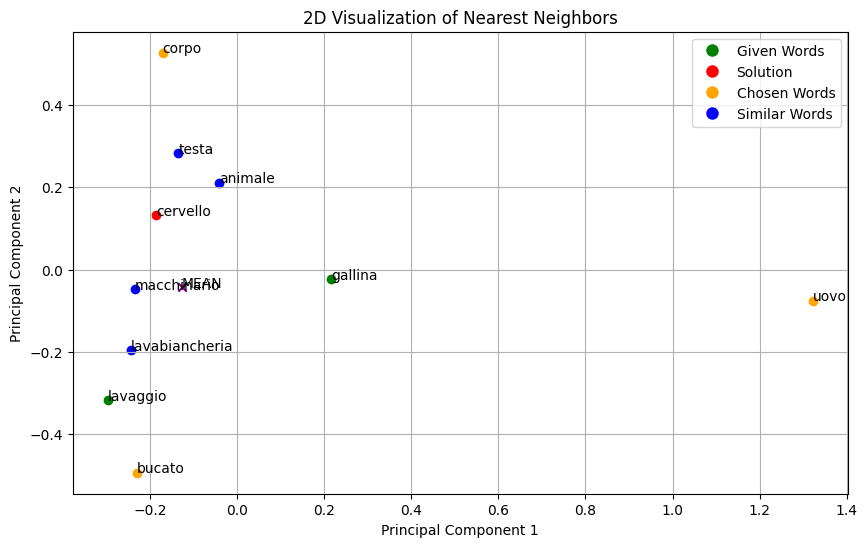

In [ ]:
def plot_word_neighbors_vectorial(given_words, embeddings_model, solution=None, num_neighbors=10):
    similar_words = list((set(embeddings_model.words) & set(italian_vocab)) - set(stopwords))

    word_vectors = [embeddings_model.get_word_vector(word) for word in given_words]

    # Calcolo del vettore medio
    average_vector = np.mean(word_vectors, axis=0)

    # Calcolo della similarità tra ciascuna parola e il vettore medio
    similarities_to_mean = [cosine_similarity(embeddings_model.get_word_vector(w), average_vector) for w in similar_words]

    word_similarity_pairs = list(zip(similar_words, similarities_to_mean))
    word_similarity_pairs.sort(key=lambda x: x[1], reverse=True)

    # Seleziono le parole simili migliori
    top_similar_words = [w for w, _ in word_similarity_pairs[:num_neighbors]]
    print(top_similar_words)
    if solution in top_similar_words:
      print("ODDIO!")

    else:
      # Aggiungo la soluzione alla lista
      top_similar_words.append(solution)

    # Selezione delle top 3 parole più vicine al vettore medio
    #top_similar_mean_words_indices = np.argsort(similarities_to_mean)[-3:]

    # Aggiunta delle top 3 parole più vicine al vettore medio alla lista delle parole da plottare
    #top_similar_words.extend([similar_words[i] for i in top_similar_mean_words_indices])

    # Performo la riduzione della dimensionalità per la visualizzazione
    pca = PCA(n_components=2)
        # Assuming vectors is a list of vectors
    vectors = [embeddings_model.get_word_vector(w) for w in top_similar_words]
    reduced_vectors = pca.fit_transform(vectors)

    reduced_average_vector = pca.transform(X=[average_vector])[0]
    # Plotting
    plt.figure(figsize=(10, 6))

    # Plotto i punti per le parole
    different_count = 0
    for i, w in enumerate(top_similar_words):
        color = 'r' if w == solution else 'g' if w in given_words else 'orange' if w != solution and w not in given_words and different_count < 3 else 'b'
        if color == 'orange':
            different_count += 1
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], marker='o', color=color)
        plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], w)


    # Plotto il punto per il vettore medio
    plt.scatter(reduced_average_vector[0], reduced_average_vector[1], marker='x', color='purple')
    plt.text(reduced_average_vector[0], reduced_average_vector[1], 'MEAN')

        # Add legend with custom labels and colors
    legend_labels = {
        'Given Words': 'green',
        'Solution': 'red',
        'Chosen Words': 'orange',
        'Similar Words': 'blue'
    }
    plt.legend(labels=legend_labels.keys(), handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
        for color in legend_labels.values()
    ])

    plt.title("2D Visualization of Nearest Neighbors")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

given_words = ["posto", "artificiale", "lavaggio", "allenare", "gallina"]  # Esempio di parole date
solution = "cervello"  # Soluzione target
plot_word_neighbors_vectorial(given_words, ft, solution=solution, num_neighbors=10)

['cervello', 'lavaggio', 'gallina', 'corpo', 'animale', 'macchinario', 'uovo', 'intelligenza', 'bucato', 'meccanico']
ODDIO!


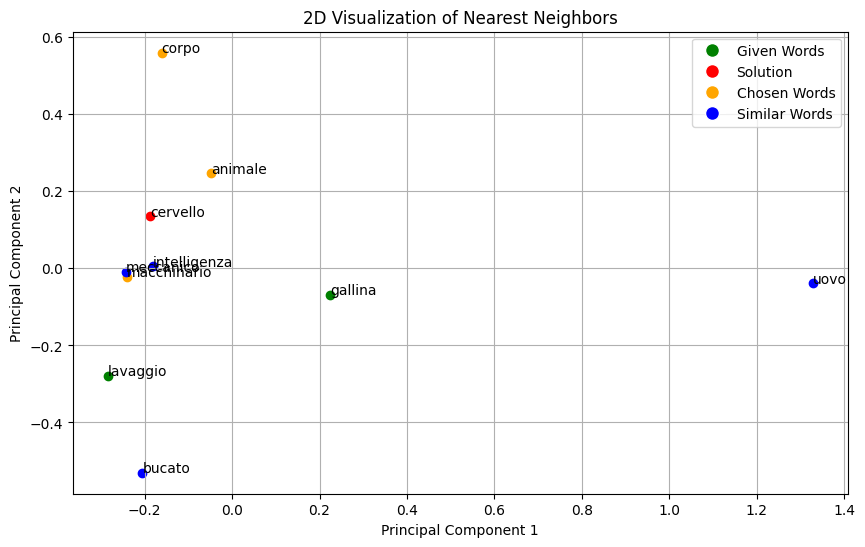

In [ ]:
def plot_word_neighbors_probabilistic(given_words, embeddings_model, solution=None, num_neighbors=10):
    similar_words = list((set(embeddings_model.words) & set(italian_vocab)) - set(stopwords))

    word_vectors = [embeddings_model.get_word_vector(word) for word in given_words if word in embeddings_model.words]
    similarity_probs = np.ones(len(similar_words))/len(similar_words)

    for i in word_vectors:
        probs = np.array([cosine_similarity(embeddings_model.get_word_vector(w), i) for w in similar_words])
        probs = np.exp(probs) / (np.sum(np.exp(probs), axis=0))
        similarity_probs = np.multiply(similarity_probs, probs)

    word_similarity_pairs = list(zip(similar_words, similarity_probs))
    word_similarity_pairs.sort(key=lambda x: x[1], reverse=True)

    # Selecting top similar words
    top_similar_words = [w for w, _ in word_similarity_pairs[:num_neighbors]]
    print(top_similar_words)
    if solution in top_similar_words:
      print("ODDIO!")
    else:
      top_similar_words.append(solution)


    # Perform dimensionality reduction for visualization
    pca = PCA(n_components=2)
    #vectors = [embeddings_model.get_word_vector(w) for w in top_similar_words]

    # Assuming vectors is a list of vectors
    vectors = [embeddings_model.get_word_vector(w) for w in top_similar_words]

    reduced_vectors = pca.fit_transform(vectors)

    # Plotting
    plt.figure(figsize=(10, 6))
    different_count = 0
    for i, w in enumerate(top_similar_words):
        color = 'r' if w == solution else 'g' if w in given_words else 'orange' if w != solution and w not in given_words and different_count < 3 else 'b'
        if color == 'orange':
            different_count += 1
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], marker='o', color=color)
        plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], w)

            # Add legend with custom labels and colors
    legend_labels = {
        'Given Words': 'green',
        'Solution': 'red',
        'Chosen Words': 'orange',
        'Similar Words': 'blue'
    }
    plt.legend(labels=legend_labels.keys(), handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
        for color in legend_labels.values()
    ])

    plt.title("2D Visualization of Nearest Neighbors")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    #plt.legend()
    plt.grid(True)
    plt.show()

given_words = ["posto", "artificiale", "lavaggio", "allenare", "gallina"]  # Esempio di parole date
solution = "cervello"  # Soluzione target
plot_word_neighbors_probabilistic(given_words, ft, solution=solution, num_neighbors=10)

Code for producing needed .jsonl objects, as commented in the report, one of the choices performed was to shuffle the position of the solution in the list of choices, adjusting accordingly the label.

In [ ]:
# Open JSON file
with open('GhigliottinaDataset.json', 'r') as file:
    data = json.load(file)

with jsonlines.open("dataset.jsonl", 'w') as writer:
    # Iterate over JSON data
    for item in data:
        given_words = [item['w1'], item['w2'], item['w3'], item['w4'], item['w5']]
        solution = item['solution']
        list_distractors = generate_distractors(given_words, solution)

        # Shuffle the choices
        choices = [solution] + list_distractors
        random.shuffle(choices)

        # Get the index of the solution in the shuffled choices
        label = choices.index(solution)
        new_item = {
            "w1": item['w1'],
            "w2": item['w2'],
            "w3": item['w3'],
            "w4": item['w4'],
            "w5": item['w5'],
            "choices": choices,
            "label": label
        }
        writer.write(new_item)

['corpo', 'animale', 'macchinario']
['apparizione', 'conseguenza', 'divenire']
['magnifica', 'mare', 'stupenda']
['riferimento', 'impegno', 'dato']
['personale', 'casa', 'pubblico']
['giro', 'finire', 'veneto']
['cittadella', 'medicina', 'piazzetta']
['colpo', 'passaggio', 'segno']
['magnifica', 'stupenda', 'festa']
['finire', 'inizio', 'particolare']
['posizione', 'strada', 'considerazione']
['aeroplano', 'rotto', 'debituccio']
['finire', 'ovvio', 'giusto']
['pallettone', 'pianoforte', 'tappeto']
['classica', 'tipo', 'particolare']
['giro', 'finire', 'mezzogiorno']
['casa', 'storia', 'particolare']
['sabbia', 'messe', 'pasta']
['combinazione', 'scarpina', 'classico']
['buca', 'teste', 'fila']
['anima', 'forte', 'bellezza']
['corpo', 'dato', 'calare']
['ritmo', 'santo', 'suono']
['finire', 'costo', 'duro']
['drago', 'castello', 'serpente']
['iniziale', 'seconda', 'suddetta']
['imperatore', 'pistolone', 'muro']
['politica', 'prospettiva', 'proccupazione']
['nord', 'giro', 'centro']
['bi

Code for shuffling and splitting datasets into development and test with a 80/20

In [ ]:
ratio = 0.8

# Open dataset.jsonl file
with jsonlines.open('dataset.jsonl', 'r') as reader:
    data = list(reader)

# Shuffle the data
random.shuffle(data)

# Calculate the split index
split_index = int(ratio * len(data))

# Split the data into train and test sets
train_data = data[:split_index]
test_data = data[split_index:]

#adding ids!
for id, item in enumerate(train_data):
  item['id'] = f"Ghigliottina-AI-task1-train-data-{id}"

for id, item in enumerate(test_data):
  item['id'] = f"Ghigliottina-AI-task1-test-data-{id}"

# Write train data to train.jsonl
with jsonlines.open("Ghigliottin-AI-task1-train-data.jsonl", 'w') as train_writer:
    # Write train data to train.jsonl
    train_writer.write_all(train_data)

# Write test data to test.jsonl
with jsonlines.open("Ghigliottin-AI-task1-test-data.jsonl", 'w') as test_writer:
    # Write test data to test.jsonl
    test_writer.write_all(test_data)

In [ ]:
prompts_list = ["Date le seguenti parole: {{w1}}, {{w2}}, {{w3}}, {{w4}}, {{w5}}, quale delle seguenti parole si collega a tutte le altre tra le opzioni seguenti: {{choices}}?",
    "Nel gioco della Ghigliottina, quale parola tra le seguenti opzioni: {{choices}}, è connessa a tutte le parole seguenti: {{w1}}, {{w2}}, {{w3}}, {{w4}}, {{w5}}?",
    "Data questa serie di parole: {{w1}}, {{w2}}, {{w3}}, {{w4}}, {{w5}}, quale parola tra le opzioni seguenti: {{choices}} è in connessione con tutte le precedenti?",
    "Il gioco della Ghigliottina consiste nel individuare la parola tra quelle proposte che si collega a tutte le parole date. Date le parole {{w1}}, {{w2}}, {{w3}}, {{w4}}, {{w5}}, quale parola tra le opzioni seguenti: {{choices}} è la soluzione?",
    "Nel gioco della Ghigliottina, date le seguenti parole {{w1}}, {{w2}}, {{w3}}, {{w4}}, {{w5}}, quale parola tra le seguenti opzioni è la soluzione? Opzioni: {{choices}}"]

In [ ]:
with jsonlines.open('Ghigliottin-AI-task1-prompt.jsonl', 'w') as writer:
  for prompt in prompts_list:
    data = {"prompt": prompt}
    writer.write(data)

Code to verify correctness of produced .jsonl files, example of populating prompt templates accordingly.

In [ ]:
def verify_correctness(file_path, num_samples, prompts_list):
  # Read the JSONL file line by line
  env = jinja2.Environment()
  with open(file_path, 'r') as f:
      i = 0
      for line in f:
          if i >= num_samples:
              break

          # Parse JSON from each line
          data = json.loads(line)

          # Iterate over the prompts list
          for prompt in prompts_list:
              template = env.from_string(prompt)
              # Replace placeholders with data values
              filled_prompt = template.render(w1 = data['w1'], w2 = data['w2'], w3 = data['w3'], w4 = data['w4'], w5 = data['w5'],
                                            choices=', '.join(data['choices']))
              print(i,filled_prompt)
              print("LABEL:", data['choices'][int(data['label'])])

          i += 1

verify_correctness('dataset.jsonl',2, prompts_list)


0 Date le seguenti parole: posto, artificiale, lavaggio, allenare, gallina, quale delle seguenti parole si collega a tutte le altre tra le opzioni seguenti: animale, corpo, macchinario, cervello?
LABEL: cervello
0 Nel gioco della Ghigliottina, quale parola tra le seguenti opzioni: animale, corpo, macchinario, cervello, è connessa a tutte le parole seguenti: posto, artificiale, lavaggio, allenare, gallina?
LABEL: cervello
0 Data questa serie di parole: posto, artificiale, lavaggio, allenare, gallina, quale parola tra le opzioni seguenti: animale, corpo, macchinario, cervello è in connessione con tutte le precedenti?
LABEL: cervello
0 Il gioco della Ghigliottina consiste nel individuare la parola tra quelle proposte che si collega a tutte le parole date. Date le parole posto, artificiale, lavaggio, allenare, gallina, quale parola tra le opzioni seguenti: animale, corpo, macchinario, cervello è la soluzione?
LABEL: cervello
0 Nel gioco della Ghigliottina, date le seguenti parole posto, ar